## This notebook has two goals:
- compare Poliastro propagation results with the software DRAMA (OSCAR)
- study the lifetime of the satellite depending on the chosen cross section

In [1]:
import sys
from typing import Tuple, Callable

from astropy import units as u
from astropy.time import Time, TimeDelta
from datetime import datetime
import numpy as np
from poliastro.bodies import Earth

from scipy.signal import lfilter


sys.path.insert(0, "../")
from digital_twin.plotting import plot_1d, find_x_scale, plot_1d_multiple

The EOP file 'finals2000A.all' in /Users/mathildesimoni/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/mathildesimoni/src/iers/ is already the latest.


In [2]:
earth_R = Earth.R.to(u.km)  # Earth's radius (km)

## Comapre results with Drama

### 1. Extract data from DRAMA

In [3]:
def read_orbital_elements(filename):
    with open(filename, "r") as file:
        lines = file.readlines()
    # print(lines)

    # Look for the start of the orbital elements table
    for i, line in enumerate(lines):
        if "Title  : Orbital evolution" in line:
            data_start = i + 6

    length = len(lines[data_start:])

    data_time = []
    data_orbital_elements = np.zeros((length, 7))
    for i, line in enumerate(lines[data_start:]):
        line = line.strip("\n ").split()
        data_time.append(" ".join([line[0], line[1]]))
        data_orbital_elements[i] = line[2:]

    return data_time, data_orbital_elements


def read_solar_activity(filename):
    with open(filename, "r") as file:
        lines = file.readlines()
    # print(lines)

    # Look for the start of the orbital elements table
    for i, line in enumerate(lines):
        if "Title  : Solar and geomagnetic activity" in line:
            data_start = i + 10
    length = len(lines[data_start:])

    data_time = []
    data_solar_activity = np.zeros((length, 3))

    for i, line in enumerate(lines[data_start:]):
        line = line.strip("\n ").split()
        data_time.append(line[0])
        data_solar_activity[i] = line[1:]

    return data_time, data_solar_activity

In [4]:
type_sim = "500km_sa_not_cst_3"
subfolder = "logs_500km_sa_not_cst_3/"
filename_orbital_elements = "CHESS_decay_v9.oev"
filename_solar_activity = "CHESS_decay_v9.osg"

folder = "logs_DRAMA/"
path_orbital_elements = folder + subfolder + filename_orbital_elements
path_solar_activity = folder + subfolder + filename_solar_activity
save_folder = "DRAMA_results/"

In [5]:
# Orbital elements
times, orbital_elements = read_orbital_elements(path_orbital_elements)
# print("Orbital Elements Table:\n", orbital_elements)
times = np.array(
    [Time(string_date, format="iso", scale="utc") for string_date in times]
)
initial_time = times[0]
final_time = times[-1]
tofs = np.array(
    [TimeDelta(time - initial_time).sec for time in times]
)  # Outputs in seconds
duration_sim = TimeDelta(final_time - initial_time)
altitudes = orbital_elements[:, 1] - earth_R.value

# Solar activity
times_sa, solar_activity = read_solar_activity(path_solar_activity)
times_sa_string = times_sa
# print("Solar Activity Table:\n", solar_activity)
times_sa = np.array(
    [Time.strptime(string_date, "%d/%m/%Y") for string_date in times_sa]
)
initial_time_sa = times_sa[0]
final_time_sa = times_sa[-1]
tofs_sa = np.array(
    [TimeDelta(time_sa - initial_time_sa).sec for time_sa in times_sa]
)  # Outputs in seconds
duration_sa = TimeDelta(final_time_sa - initial_time_sa)
F10 = solar_activity[:, 0]
Ap = solar_activity[:, 2]

/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


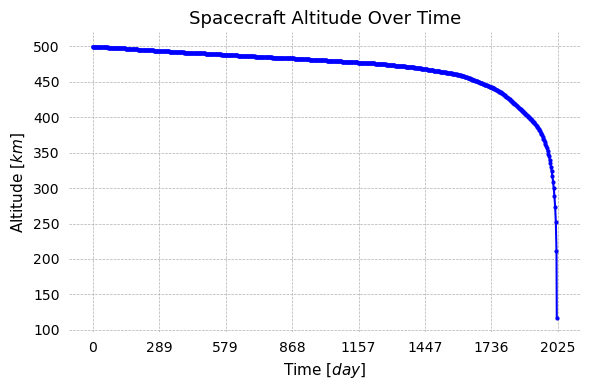

In [6]:
# plot altitude
x_label, x_label_f = find_x_scale(duration_sim)
step = 1

plot_1d(
    tofs,
    altitudes,
    "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude $\left[km\right]$",
    step=step,
    fill_under=False,
    remove_box=True,
    y_range=(min(altitudes) - 20, max(altitudes) + 20),
    x_label_f=x_label_f,
    show=True,
    save_filename=save_folder + type_sim + "_altitude.jpg",
)

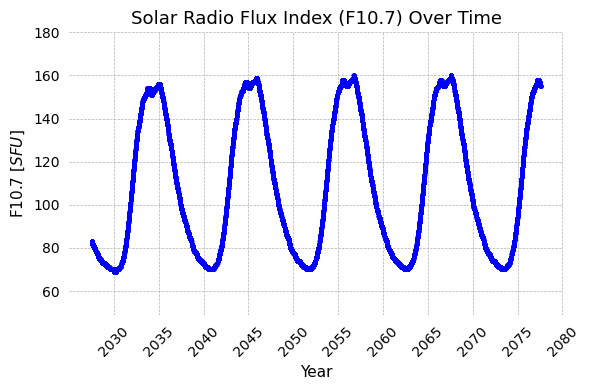

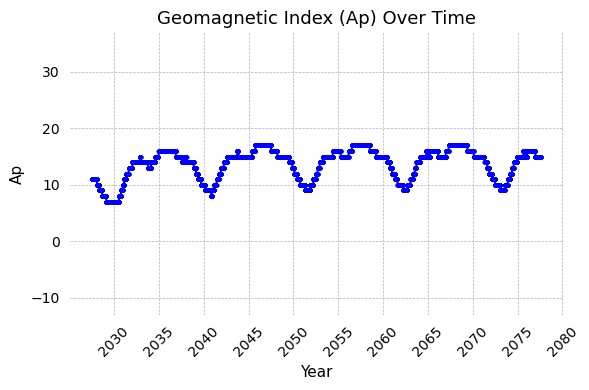

In [7]:
# plot solar activity
x_label = "Year"
step = 1

plot_1d(
    [datetime.strptime(date, "%d/%m/%Y") for date in times_sa_string],
    F10,
    "Solar Radio Flux Index (F10.7) Over Time",
    x_label,
    r"F10.7 $\left[SFU\right]$",
    step=step,
    fill_under=False,
    remove_box=True,
    y_range=(min(F10) - 20, max(F10) + 20),
    show=True,
    save_filename=save_folder + type_sim + "_F10.jpg",
    date_x_axis=True,
    date_interval=365 * 5,
    date_format="%Y",
)

plot_1d(
    [datetime.strptime(date, "%d/%m/%Y") for date in times_sa_string],
    Ap,
    "Geomagnetic Index (Ap) Over Time",
    x_label,
    r"Ap",
    step=step,
    fill_under=False,
    remove_box=True,
    y_range=(min(Ap) - 20, max(Ap) + 20),
    show=True,
    save_filename=save_folder + type_sim + "_Ap.jpg",
    date_x_axis=True,
    date_interval=365 * 5,
    date_format="%Y",
)

In [8]:
# save the data in numpy arrays
with open(save_folder + type_sim + "_times.npy", "wb") as f:
    np.save(f, tofs)
with open(save_folder + type_sim + "_altitudes.npy", "wb") as f:
    np.save(f, altitudes)
with open(save_folder + type_sim + "_times_sa.npy", "wb") as f:
    np.save(f, tofs_sa)
with open(save_folder + type_sim + "_dates_sa.npy", "wb") as f:
    np.save(f, times_sa)
with open(save_folder + type_sim + "_F10.npy", "wb") as f:
    np.save(f, F10)
with open(save_folder + type_sim + "_Ap.npy", "wb") as f:
    np.save(f, Ap)

### 2. Compare with results from the propagator

In [11]:
# DRAMA data
times_DRAMA = np.load(save_folder + type_sim + "_times.npy")
altitudes_DRAMA = np.load(save_folder + type_sim + "_altitudes.npy")

# Poliastro propagator data
results_folder = "../../results/data/"
times = np.load(results_folder + "times.npy")
altitudes = np.load(results_folder + "altitude.npy")

169776000.0
174549896.0
169776000.0


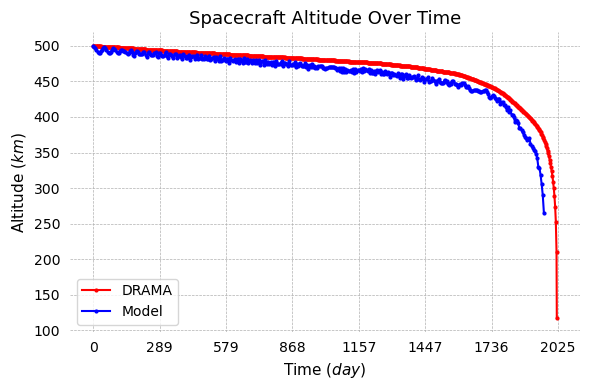

In [12]:
duration_sim_DRAMA = TimeDelta(times_DRAMA[-1])
duration_sim = TimeDelta(times[-1])
print(duration_sim)
duration = max(duration_sim, duration_sim_DRAMA)
x_label, x_label_f = find_x_scale(duration)

steps = [1, 700]
labels = ["DRAMA", "Model"]
colors = ["red", "blue"]
xs = [times_DRAMA, times]
ys = [altitudes_DRAMA, altitudes]

print(times_DRAMA[-1])
print(times[-1])

plot_1d_multiple(
    xs,
    ys,
    "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude $\left[km\right]$",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=save_folder + type_sim + "_lifetime_comparison.jpg",
)

## Study lifetime based on the chosen cross section

In [9]:
# Poliastro propagator data
results_folder = "propagation_results/"
times_avg = np.load(results_folder + "times_avg_cross_section.npy")
altitudes_avg = np.load(results_folder + "altitude_avg_cross_section.npy")

times_high = np.load(results_folder + "times_high_cross_section.npy")
altitudes_high = np.load(results_folder + "altitude_high_cross_section.npy")

times_low = np.load(results_folder + "times_low_cross_section.npy")
altitudes_low = np.load(results_folder + "altitude_low_cross_section.npy")


# Smoothen altitudes
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

altitudes_avg_f = lfilter(b, a, altitudes_avg)[20:]
times_avg_f = times_avg[20:]

altitudes_high_f = lfilter(b, a, altitudes_high)[20:]
times_high_f = times_high[20:]

altitudes_low_f = lfilter(b, a, altitudes_low)[20:]
times_low_f = times_low[20:]

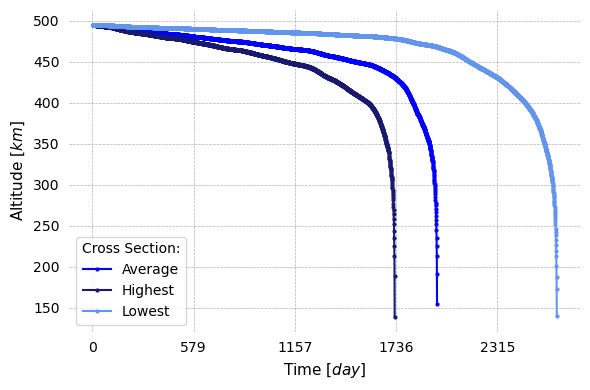

In [24]:
duration_sim_avg = TimeDelta(times_avg[-1])
duration_sim_high = TimeDelta(times_high[-1])
duration_sim_low = TimeDelta(times_low[-1])
duration = max(duration_sim_avg, duration_sim_high, duration_sim_low)
x_label, x_label_f = find_x_scale(duration)

steps = [100, 100, 100]
labels = ["Average", "Highest", "Lowest"]
colors = ["blue", "midnightblue", "cornflowerblue"]
xs = [times_avg_f[:-100], times_high_f[:-100], times_low_f]
ys = [altitudes_avg_f[:-100], altitudes_high_f[:-100], altitudes_low_f]

plot_1d_multiple(
    x=xs,
    y=ys,
    title="",  # "Spacecraft Altitude Over Time",
    xlabel=x_label,
    ylabel=r"Altitude $\left[km\right]$",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=results_folder + "lifetime_comparison_cross_section.jpg",
    legend_title="Cross Section:",
)